In [1]:
!pip install transformers
!pip install torch
!pip install sklearn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 55.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post5-py3-none-any.whl size=2950 sha256=acee209136ddb40bdf0d24960226bae4dece652f4071eb051c2c1b33a2a26561
  Stored in directory: /root/.cache/pip/wheels/38/1f/8d/4f812c590e074c1e928f5cec67bf5053b71f38e2648739403a
Successfully built sklearn


In [5]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd



In [7]:
df = pd.read_csv('/content/Laptop_datasets.csv')  # Replace 'dataset.csv' with your dataset file

# Preprocessing the dataset
text_data = df['text'].values
aspect_data = df['aspect'].values
label_data = df['label'].values
import numpy as np

# Map labels to numerical values
label_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}
label_data = np.array([label_mapping[label] for label in label_data])

# Tokenize the input data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

input_ids = []
attention_masks = []

for text, aspect in zip(text_data, aspect_data):
    encoded_data = tokenizer.encode_plus(
        text,
        aspect,
        add_special_tokens=True,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    input_ids.append(encoded_data['input_ids'])
    attention_masks.append(encoded_data['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
label_data = torch.tensor(label_data)

# Create DataLoader
dataset = TensorDataset(input_ids, attention_masks, label_data)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


In [8]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [9]:
def evaluate(model, dataloader):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in dataloader:
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_mask, labels = batch

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            _, predicted_labels = torch.max(logits, dim=1)

            predictions.extend(predicted_labels.detach().cpu().numpy())
            true_labels.extend(labels.detach().cpu().numpy())

    return true_labels, predictions


Precision: 0.4241959937081889
Recall: 0.36225098723747434
F1-Score: 0.27211029161600675
Accuracy: 0.28793774319066145


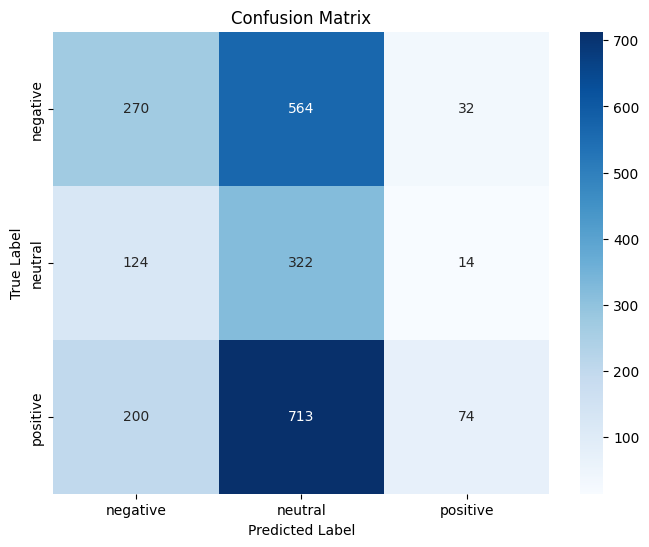

In [ ]:
true_labels, predictions = evaluate(model, dataloader)

# Compute evaluation metrics
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')
f1 = f1_score(true_labels, predictions, average='macro')
accuracy = accuracy_score(true_labels, predictions)

print('Precision:', precision)
print('Recall:', recall)
print('F1-Score:', f1)
print('Accuracy:', accuracy)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)
class_names = ['negative', 'neutral', 'positive']
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
